In [1]:
# https://levelup.gitconnected.com/audio-data-analysis-using-deep-learning-part-1-7f6e08803f60
# https://habr.com/ru/company/dataart/blog/343464/
# https://habr.com/ru/post/140828/ - мел-кепстральные коэф
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os, sys, copy, time, csv, pickle, PIL
import sklearn

In [2]:
from sklearn import tree as tr
from sklearn import ensemble as ens
from sklearn import model_selection as ms
from sklearn import linear_model as lm
from sklearn import metrics as mt

In [3]:
import keras
import tensorflow as tf
import keras.backend as K
import keras.layers as kl

Using TensorFlow backend.


In [10]:
import IPython.display as ipd

In [4]:
def TPFPTNFN(y, y_pred):
    d = {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0}
    for i in range(len(y)):
        if (y[i]==1) and (y_pred[i]==1): d['TP'] = d['TP'] + 1 
        if (y[i]==1) and (y_pred[i]==0): d['FN'] = d['FN'] + 1 
        if (y[i]==0) and (y_pred[i]==1): d['FP'] = d['FP'] + 1 
        if (y[i]==0) and (y_pred[i]==0): d['TN'] = d['TN'] + 1 
    return d

In [11]:
ipd.Audio(r'D:\Competitions_Tasks\Sber1\bad16000\_2.wav')

<class 'numpy.ndarray'> <class 'int'>
(110250,) 22050


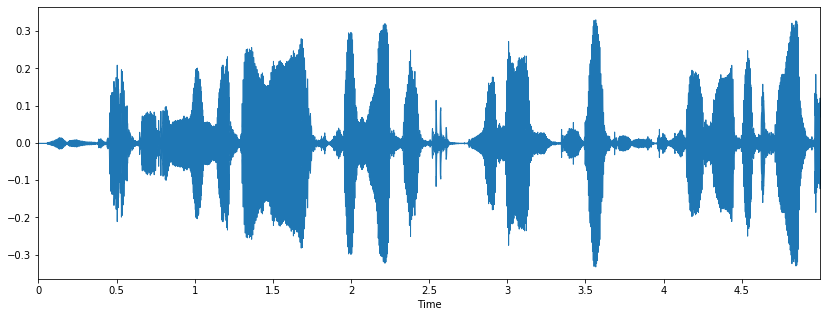

In [17]:
audio_data = r'D:\Competitions_Tasks\Sber1\bad16000\_2.wav'
x , sr = librosa.load(audio_data, duration = 5)
#x , sr = librosa.load(audio_data, sr=44100)
print(type(x), type(sr))
#<class 'numpy.ndarray'> <class 'int'>
print(x.shape, sr)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)#[10000:13000]

# Data from only audio road - dataset formation

In [6]:
def ToAudioEmbeds(file_, emb_size = 1000, duration = 5):
    x , sr = librosa.load(audio_data, duration = duration)
    return np.array([x[emb_size*i:emb_size*(i+1)] for i in range(x.shape[0]//emb_size)])

ToAudioEmbeds(r'D:\Competitions_Tasks\Sber1\bad16000\_2.wav').shape

(110, 1000)

In [8]:
#good = np.array([ToAudioEmbeds(i, emb_size=1000) for i in os.listdir(r'D:\Competitions_Tasks\Sber1\good16000')])
#np.save(file = r'D:\Competitions_Tasks\Sber1\good_1000.npy', arr=good)
#good = np.load(file = r'D:\Competitions_Tasks\Sber1\good.npy')

In [9]:
#bad = np.array([ToAudioEmbeds(i, emb_size=1000) for i in os.listdir(r'D:\Competitions_Tasks\Sber1\bad16000')])
#np.save(file = r'D:\Competitions_Tasks\Sber1\bad_1000.npy', arr=bad)
#bad = np.load(file = r'D:\Competitions_Tasks\Sber1\bad.npy')

In [10]:
#good.shape, bad.shape

In [11]:
#X = np.concatenate([good, bad], axis = 0)
#Y = np.array([1]*good.shape[0] + [0]*bad.shape[0])
#X.shape, Y.shape

In [12]:
#X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2)

In [128]:
#https://github.com/CyberZHG/keras-self-attention
i0 = kl.Input(shape = good.shape[1:])
l1 = kl.GRU(good.shape[2]//4, return_sequences=True)(i0)
l2a = kl.Dropout(0.15)(l1)
l4 = kl.GRU(good.shape[2]//4, return_sequences=True)(l2a)
l4quer = kl.Conv1D(good.shape[2]//4, 1)(l4)
l4keys = kl.Conv1D(good.shape[2]//4, 1)(l4)
l4vals = kl.Conv1D(good.shape[2]//4, 1)(l4)
l4matmul = kl.Lambda(lambda X: tf.matmul(X[0], X[1], transpose_b=True))([l4quer, l4keys])
l4sft = kl.Softmax(axis = -1)(l4matmul)
l4att = kl.Lambda(lambda X: tf.matmul(X[0], X[1], transpose_b=False))([l4sft, l4vals])
l4att_fin = kl.Lambda(lambda X: tf.reduce_sum(X, axis = -2))(l4att)
l5 = kl.Dense(good.shape[2]//4)(l4att_fin)
l5a = kl.Dropout(0.2)(l5)
l6 = kl.Dense(good.shape[2]//8)(l5a)
l7 = kl.Dense(1, activation='sigmoid')(l6)

md = keras.models.Model(inputs = [i0, ], outputs = [l7, ])
md.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 110, 1000)    0                                            
__________________________________________________________________________________________________
gru_50 (GRU)                    (None, 110, 250)     938250      input_21[0][0]                   
__________________________________________________________________________________________________
dropout_32 (Dropout)            (None, 110, 250)     0           gru_50[0][0]                     
__________________________________________________________________________________________________
gru_51 (GRU)                    (None, 110, 250)     375750      dropout_32[0][0]                 
__________________________________________________________________________________________________
conv1d_25 

In [131]:
callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1),
            keras.callbacks.ModelCheckpoint(r'D:\Competitions_Tasks\Sber1\GRU_W_v1.h5',
                                            monitor='val_loss', verbose=1, save_best_only=False,)]

#md.compile(optimizer = keras.optimizers.Adam(lr=0.01),
#    loss=keras.losses.binary_crossentropy,
#    metrics=['accuracy'])

In [132]:
#fitted = md.fit(X_train, y_train, batch_size=16,epochs=50,verbose=1,
#    callbacks=callbacks, validation_data=[X_test, y_test],)

# Audio road features

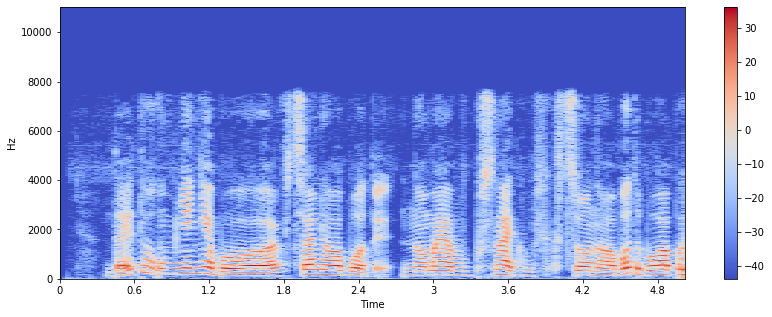

In [7]:
X = librosa.stft(x) # Разложение временного ряда аудио в соотвествии с разложением Фурье(по спектрам)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [9]:
X.shape

(1025, 216)

In [490]:
#plt.figure(figsize=(14, 5))
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
#plt.colorbar()

In [492]:
#Спектральный центроид указывает, на какой частоте сосредоточена энергия спектра,
#или, другими словами, он указывает, где находится ” центр масс” звука. Это как взвешенное среднее:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
# Computing the time variable for visualization
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
#librosa.display.waveplot(x, sr=sr, alpha=0.4)
#plt.plot(t, normalize(spectral_centroids), color='b')

<Figure size 864x288 with 0 Axes>

In [493]:
#Это мера формы сигнала. Он представляет частоту, на которой высокие частоты снижаются до 0.
#Чтобы получить его, мы должны вычислить долю бункеров в спектре мощности,
#где 85% его мощности приходится на более низкие частоты.
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))
#librosa.display.waveplot(x, sr=sr, alpha=0.4)
#plt.plot(t, normalize(spectral_rolloff), color='r')

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

In [494]:
#Спектральная полоса определяется как ширина полосы света на половине максимума пика
#(или полная ширина на половине максимума [FWHM]) и представлена двумя вертикальными красными линиями
#и λSB на оси длины волны.
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(15, 9))
#librosa.display.waveplot(x, sr=sr, alpha=0.4)
#plt.plot(t, normalize(spectral_bandwidth_2), color='r')
#plt.plot(t, normalize(spectral_bandwidth_3), color='g')
#plt.plot(t, normalize(spectral_bandwidth_4), color='y')
#plt.legend(('p = 2', 'p = 3', 'p = 4'))

<Figure size 1080x648 with 0 Axes>

<Figure size 1080x648 with 0 Axes>

In [496]:
#Очень простой способ измерения гладкости сигнала-вычислить число пересечений нуля в пределах сегмента этого сигнала.
#Голосовой сигнал колеблется медленно — например, сигнал 100 Гц будет пересекать ноль 100 в секунду
#- в то время как беззвучный фрикатив может иметь 3000 нулевых пересечений в секунду.
#Plot the signal:
#plt.figure(figsize=(14, 5))
#librosa.display.waveplot(x, sr=sr)
# Zooming in
n0 = 9000
n1 = 9100
#plt.figure(figsize=(14, 5))
#plt.plot(x[n0:n1])
#plt.grid()

In [497]:
#Mel-частотные коэффициенты (MFCCs) сигнала представляют собой
#небольшой набор признаков (обычно около 10-20), которые кратко описывают общую форму спектральной огибающей.
#Он моделирует характеристики человеческого голоса.
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)
(20, 97)
#Displaying  the MFCCs:
#plt.figure(figsize=(15, 7))
#librosa.display.specshow(mfccs, sr=sr, x_axis='time')

(20, 216)


(20, 97)

In [498]:
#Хроматический признак или вектор обычно представляет собой 12-элементный вектор признаков,
#указывающий, сколько энергии каждого класса высоты тона , 
#{C, C#, D, D#, E,..., B}, присутствует в сигнале. Короче говоря ,
#он обеспечивает надежный способ описания меры сходства между музыкальными произведениями.
chromagram = librosa.feature.chroma_stft(x, sr=sr, )#hop_length=5)
#plt.figure(figsize=(15, 5))
#librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')#, hop_length=5

# Data set formation with features

In [15]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
dir1 = r'D:\Competitions_Tasks\Sber1\bad16000'
dir2 = r'D:\Competitions_Tasks\Sber1\good16000'
dirs = [dir1, dir2]
#for dir_ in dirs:
#    print(dir_)
#    os.chdir(dir_)
#    for filename in os.listdir(dir_):
#        y, sr = librosa.load(filename, mono=True, duration=10)
#        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
#        plt.axis('off')
#        plt.savefig(os.path.join(dir_ + '_PNGs', filename[:filename.index('.')] + '.png'))
#        plt.clf()

<Figure size 576x576 with 0 Axes>

In [134]:
dir1 = r'D:\Competitions_Tasks\Sber1\bad16000'
dir2 = r'D:\Competitions_Tasks\Sber1\good16000'
dirs = [dir1, dir2]

for dir_ in dirs:
    os.chdir(dir_)
    post = os.path.split(dir_)[1]
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header = header.split()
    file = open(r'D:\Competitions_Tasks\Sber1\dataset_%s.csv'%post, 'w', newline='')
    print(r'D:\Competitions_Tasks\Sber1\dataset_%s.csv'%post)
    with file:
        writer = csv.writer(file)
        writer.writerow(header)
    for filename in os.listdir():
        y, sr = librosa.load(filename, mono=True, duration=30)
        rms = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = [filename, str(np.mean(chroma_stft)), str(np.mean(rms)), str(np.mean(spec_cent)),
                     str(np.mean(spec_bw)), str(np.mean(rolloff)), str(np.mean(zcr))]    
        for e in mfcc:
            to_append = to_append + [np.mean(e)] #f' {np.mean(e)}'
        file = open(r'D:\Competitions_Tasks\Sber1\dataset_%s.csv'%post, 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append)

D:\Competitions_Tasks\Sber1\dataset_bad16000.csv
D:\Competitions_Tasks\Sber1\dataset_good16000.csv


# Network tests - only on features(no pictures)

In [23]:
#ff = open(r'D:\Competitions_Tasks\Sber1\dataset_bad16000.csv', 'r')
#rdr = csv.reader(ff)
#data_bad0 = [row for row in rdr]
#data_bad = np.array(data_bad0[1:])[:, 1:].astype(float)
#ff.close()

In [24]:
#ff = open(r'D:\Competitions_Tasks\Sber1\dataset_good16000.csv', 'r')
#rdr = csv.reader(ff)
#data_good0 = [row for row in rdr]
#data_good = np.array(data_good0[1:])[:, 1:].astype(float)
#ff.close()

In [12]:
ff = open(r'D:\Competitions_Tasks\Sber1\dataset_bad_new.csv', 'r')
rdr = csv.reader(ff)
data_bad0 = [row for row in rdr]
data_bad = np.array(data_bad0[1:])[:, 1:].astype(float)
ff.close()

In [13]:
ff = open(r'D:\Competitions_Tasks\Sber1\dataset_good_new.csv', 'r')
rdr = csv.reader(ff)
data_good0 = [row for row in rdr]
data_good = np.array(data_good0[1:])[:, 1:].astype(float)
ff.close()

In [14]:
ff = open(r'D:\Competitions_Tasks\Sber1\dataset_bad1_upd.csv', 'r')
rdr = csv.reader(ff)
data_bad0 = [row for row in rdr]
data_bad_new = np.array(data_bad0[1:])[:, 1:].astype(float)
ff.close()

In [15]:
ff = open(r'D:\Competitions_Tasks\Sber1\dataset_good1_upd.csv', 'r')
rdr = csv.reader(ff)
data_good0 = [row for row in rdr]
data_good_new = np.array(data_good0[1:])[:, 1:].astype(float)
ff.close()

In [16]:
data_bad.shape, data_good.shape, data_bad_new.shape, data_good_new.shape

((1554, 26), (13307, 26), (2060, 26), (20834, 26))

In [17]:
X = np.concatenate([data_bad, data_good, data_bad_new, data_good_new], axis = 0)
Y = np.array(data_bad.shape[0]*[0] + data_good.shape[0]*[1] + data_bad_new.shape[0]*[0] + data_good_new.shape[0]*[1])
all_ = np.concatenate([X, np.expand_dims(Y, axis = -1)], axis = -1)
np.random.shuffle(all_)
all_train = all_[:-int(X.shape[0]*0.4)]
all_val = all_[-int(X.shape[0]*0.4):-int(X.shape[0]*0.2)]
all_test = all_[-int(X.shape[0]*0.2):]
all_train.shape, all_val.shape, all_test.shape

((22653, 27), (7551, 27), (7551, 27))

In [18]:
X_tr = all_train[:, :-1]
Y_tr = all_train[:, -1]
X_val = all_val[:, :-1]
Y_val = all_val[:, -1]
X_te = all_test[:, :-1]
Y_te = all_test[:, -1]

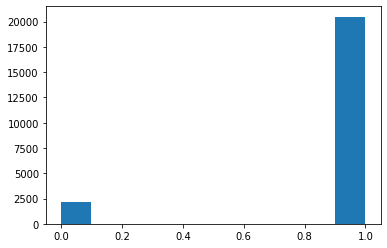

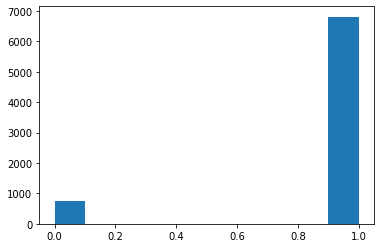

(array([ 705.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6846.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

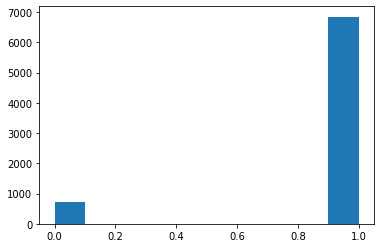

In [19]:
plt.hist(Y_tr); plt.show()
plt.hist(Y_val); plt.show()
plt.hist(Y_te)

In [20]:
pr = data_bad.shape[0]+data_bad_new.shape[0]
Xnn = np.concatenate([data_bad, data_bad_new, data_good[:pr]], axis = 0)
Ynn = np.array(data_bad.shape[0]*[0] + data_bad_new.shape[0]*[0] + pr*[1])
#print(Xnn.shape, Ynn.shape)
all_nn = np.concatenate([Xnn, np.expand_dims(Ynn, axis = -1)], axis = -1)
np.random.shuffle(all_nn)
X_trnn = all_nn[:, :-1]
Y_trnn = all_nn[:, -1]

In [21]:
np.count_nonzero(Y_tr)/Y_tr.shape[0], (Y_tr.shape[0]-np.count_nonzero(Y_tr))/Y_tr.shape[0]

(0.9042069483070675, 0.09579305169293251)

In [117]:
def WBCE(y, y_pred, weights=[1, 1]):
    eps = 10e-8
    q1 = weights[0]*y*tf.log(y_pred + eps)
    q2 = weights[1]*(1 - y)*tf.log(1 - y_pred + eps)
    return -tf.reduce_mean(q1+q2)

def SelfMetrics(y, y_pred, k=2):
    eps = 10e-8
    TP = tf.reduce_sum(y*y_pred)
    FP = tf.reduce_sum((1-y)*y_pred)
    TN = tf.reduce_sum((1-y)*(1-y_pred))
    FN = tf.reduce_sum(y*(1-y_pred))
    metr = (FN*k+FP+eps)/(TN+TP+eps)
    return metr

def F1_neg_class(y, y_pred):
    eps = 10e-8
    TP = tf.reduce_sum(y*y_pred)
    FP = tf.reduce_sum((1-y)*y_pred)
    TN = tf.reduce_sum((1-y)*(1-y_pred))
    FN = tf.reduce_sum(y*(1-y_pred))
    prec = TN/(TN+FN+eps)
    rec = TN/(TN+FP+eps)
    return (2*prec*rec)/(prec+rec+eps)

def F1_neg_class_loss(y, y_pred):
    eps = 10e-8
    TP = tf.reduce_sum(y*y_pred)
    FP = tf.reduce_sum((1-y)*y_pred)
    TN = tf.reduce_sum((1-y)*(1-y_pred))
    FN = tf.reduce_sum(y*(1-y_pred))
    prec = TN/(TN+FN+eps)
    rec = TN/(TN+FP+eps)
    return 1-(2*prec*rec)/(prec+rec+eps)

def Comb(y, y_pred, weights=[1, 3.3], k=4):
    q1 = WBCE(y, y_pred, weights=weights)
    #q2 = SelfMetrics(y, y_pred, k=k)
    q3 = F1_neg_class_loss(y, y_pred)
    return q1+q3

In [118]:
i = kl.Input(shape=X_tr.shape[1:])
l1 = kl.Dense(1024, activation='relu')(i)
l1a = kl.BatchNormalization()(l1)
l1b = kl.Dropout(0.2)(l1a)
l2 = kl.Dense(512, activation='relu')(l1b)
l3 = kl.Dense(256, activation='relu')(l2)
l3a = kl.Dropout(0.2)(l3)
l4 = kl.Dense(128, activation='relu')(l3a)
l5 = kl.Dense(64, activation='relu')(l4)
l6 = kl.Dense(1, activation='sigmoid')(l5)

model_nn = keras.models.Model(inputs=[i,], outputs=[l6,])

model_nn.compile(optimizer=keras.optimizers.Adam(lr=0.001),
    loss=Comb,
    metrics=['accuracy', F1_neg_class],)
model_nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 26)                0         
_________________________________________________________________
dense_85 (Dense)             (None, 1024)              27648     
_________________________________________________________________
batch_normalization_15 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_29 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_86 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_87 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_30 (Dropout)         (None, 256)               0         
__________

In [119]:
#model_nn.load_weights(r'D:\Competitions_Tasks\Sber1\NN_weights_best_val.h5')

In [120]:
clb = [keras.callbacks.ModelCheckpoint(r'D:\Competitions_Tasks\Sber1\NN_weights_best_val2.h5',
                                    monitor='val_loss',
                                    verbose=1,
                                    save_best_only=True,), 
       keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.1,
                                        patience=5)
      ]

In [121]:
history_ = model_nn.fit(X_tr, Y_tr, batch_size=32,
    epochs=5,
    verbose=1,
    callbacks=clb,
    validation_split=0.15)

Train on 19255 samples, validate on 3398 samples
Epoch 1/5
19255/19255 [==============================] - 53s 3ms/step - loss: 1.5937 - acc: 0.8398 - F1_neg_class: 0.1583 - val_loss: 1.5284 - val_acc: 0.8637 - val_F1_neg_class: 0.1525

Epoch 00001: val_loss improved from inf to 1.52839, saving model to D:\Competitions_Tasks\Sber1\NN_weights_best_val2.h5
Epoch 2/5
19255/19255 [==============================] - 40s 2ms/step - loss: 1.5356 - acc: 0.8728 - F1_neg_class: 0.1658 - val_loss: 1.5707 - val_acc: 0.9079 - val_F1_neg_class: 0.1463

Epoch 00002: val_loss did not improve from 1.52839
Epoch 3/5
19255/19255 [==============================] - 43s 2ms/step - loss: 1.5203 - acc: 0.8656 - F1_neg_class: 0.1711 - val_loss: 1.5160 - val_acc: 0.8693 - val_F1_neg_class: 0.1527

Epoch 00003: val_loss improved from 1.52839 to 1.51600, saving model to D:\Competitions_Tasks\Sber1\NN_weights_best_val2.h5
Epoch 4/5
19255/19255 [==============================] - 39s 2ms/step - loss: 1.5160 - acc: 0.8

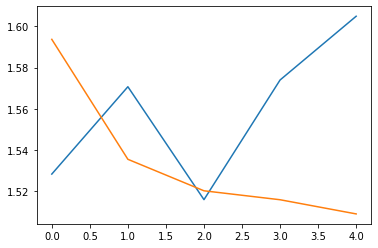

In [122]:
plt.plot(history_.history['val_loss'][:])
plt.plot(history_.history['loss'][:])

In [123]:
thresh = 0.68

In [124]:
pr1_a = model_nn.predict(X_tr)
pr1_b = model_nn.predict(X_val)
pr1_c = model_nn.predict(X_te)

In [125]:
print(TPFPTNFN(Y_tr, [1 if i>=thresh else 0 for i in pr1_a]))
print(TPFPTNFN(Y_val, [1 if i>=thresh else 0 for i in pr1_b]))
print(TPFPTNFN(Y_te, [1 if i>=thresh else 0 for i in pr1_c]))

{'TP': 19060, 'FP': 1837, 'TN': 370, 'FN': 1386}
{'TP': 6368, 'FP': 580, 'TN': 123, 'FN': 480}
{'TP': 6402, 'FP': 587, 'TN': 117, 'FN': 445}


In [ ]:
#pred var
{'TP': 9112, 'FP': 440, 'TN': 1767, 'FN': 11334}
{'TP': 2987, 'FP': 131, 'TN': 572, 'FN': 3861}
{'TP': 3038, 'FP': 165, 'TN': 539, 'FN': 3809}

In [41]:
FN = Y_tr*(1-np.array([1 if i>=thresh else 0 for i in pr1_a]))
sum(FN)

7695.0

In [77]:
# Сначала обучи дерево (внизу!)
tp = TPFPTNFN(Y_tr, tr1.predict(X_tr))
print(tp)
val_ = TPFPTNFN(Y_val, tr1.predict(X_val))
print(val_)
test_ = TPFPTNFN(Y_te, tr1.predict(X_te))
print(test_)

{'TP': 20358, 'FP': 0, 'TN': 2185, 'FN': 110}
{'TP': 6215, 'FP': 528, 'TN': 199, 'FN': 609}
{'TP': 6237, 'FP': 515, 'TN': 187, 'FN': 612}


In [78]:
# Сначала обучи дерево (внизу!)
#pr2_a = tr1.predict_proba(X_tr)[:, 1]
#pr2_b = tr1.predict_proba(X_val)[:, 1]
#pr2_c = tr1.predict_proba(X_te)[:, 1]

In [ ]:
#PRa = (pr1_a+pr2_a)/2
#PRb = (pr1_b+pr2_b)/2
#PRc = (pr1_c+pr2_c)/2

In [ ]:
#print(TPFPTNFN([1 if i>=thresh else 0 for i in model_nn.predict(X_tr)], Y_tr))
#print(TPFPTNFN([1 if i>=thresh else 0 for i in model_nn.predict(X_val)], Y_val))
#print(TPFPTNFN([1 if i>=thresh else 0 for i in model_nn.predict(X_te)], Y_te))

In [37]:
mt.confusion_matrix(Y_tr, [1 if i>=thresh else 0 for i in pr1_a])

array([[ 2006,   181],
       [ 7695, 12771]], dtype=int64)

In [36]:
mt.confusion_matrix(Y_tr, tr1.predict(X_tr))

array([[ 2187,     0],
       [   93, 20373]], dtype=int64)

# Linear models

In [ ]:
# http://zabaykin.ru/?p=600 - полезные методы оптимизации

### Training, lower we have already trained model! 

In [32]:
TR = tr.DecisionTreeClassifier(criterion='entropy',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced') #{0:1, 1:1}

TR.fit(X_tr, Y_tr)

print('Tree depth:', TR.tree_.max_depth)
RES = mt.accuracy_score(TR.predict(X_val), Y_val)     
print('Test_acc:', round(RES, 2))
RES = mt.accuracy_score(TR.predict(X_tr), Y_tr)     
print('Train_acc:', RES)

Tree depth: 36
Test_acc: 0.85
Train_acc: 0.999955855736547


In [35]:
def DesTreeCutting(step = 1, show = False, eps = 0.08):
    DepthOfBaseTree = []; depth = None
    while True:
        t0 = time.time()
        tr1 = tr.DecisionTreeClassifier(criterion='entropy',
                            splitter='best',
                            max_depth=depth,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            class_weight='balanced')
        tr1.fit(X_tr, Y_tr)
        if show: print('\t'*2, 'Acc', '\t'*2 , 'AUC')
        mt_acc_tr = round(mt.accuracy_score(tr1.predict(X_tr), Y_tr),3)
        mt_auc_tr = round(mt.roc_auc_score(tr1.predict(X_tr), Y_tr),3)
        mt_acc_val = round(mt.accuracy_score(tr1.predict(X_val), Y_val),3)
        mt_auc_val = round(mt.roc_auc_score(tr1.predict(X_val), Y_val),3)
        if show: print('Train batch: ', mt_acc_tr,'\t'*2,  mt_auc_tr)
        if show: print('valid batch:', mt_acc_val,'\t'*2, mt_auc_val)
        if show: print('Tree shape: ', tr1.tree_.max_depth)
        if len(DepthOfBaseTree)!=0:
            if (mt_auc_val+eps)<DepthOfBaseTree[-1][1]:
                print('Metrics down:', depth, mt_auc_val)
                tr1 = tr.DecisionTreeClassifier(criterion='gini',
                            splitter='best',
                            max_depth=depth,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            class_weight='balanced')
                tr1.fit(X_tr, Y_tr)
                break
        else: depth = tr1.tree_.max_depth
        DepthOfBaseTree = DepthOfBaseTree + [(depth, mt_auc_val)]
        depth = depth - step
        if depth<=0: break
        print(DepthOfBaseTree[-1])
        print('Time elapsed: ', round(time.time() - t0))
    return tr1

TREE1 = DesTreeCutting()

(42, 0.594)
Time elapsed:  3
(41, 0.585)
Time elapsed:  3
(40, 0.589)
Time elapsed:  3
(39, 0.59)
Time elapsed:  3
(38, 0.587)
Time elapsed:  3
(37, 0.587)
Time elapsed:  3
(36, 0.587)
Time elapsed:  3
(35, 0.589)
Time elapsed:  3
(34, 0.594)
Time elapsed:  3
(33, 0.588)
Time elapsed:  3
(32, 0.587)
Time elapsed:  3
(31, 0.59)
Time elapsed:  3
(30, 0.59)
Time elapsed:  3
(29, 0.592)
Time elapsed:  3
(28, 0.588)
Time elapsed:  4
(27, 0.587)
Time elapsed:  3
(26, 0.585)
Time elapsed:  2
(25, 0.585)
Time elapsed:  3
(24, 0.585)
Time elapsed:  3
(23, 0.578)
Time elapsed:  3
(22, 0.581)
Time elapsed:  2
(21, 0.573)
Time elapsed:  3
(20, 0.57)
Time elapsed:  3
(19, 0.566)
Time elapsed:  3
(18, 0.561)
Time elapsed:  3
(17, 0.556)
Time elapsed:  3
(16, 0.554)
Time elapsed:  2
(15, 0.548)
Time elapsed:  3
(14, 0.547)
Time elapsed:  3
(13, 0.543)
Time elapsed:  3
(12, 0.543)
Time elapsed:  3
(11, 0.545)
Time elapsed:  3
(10, 0.543)
Time elapsed:  2
(9, 0.544)
Time elapsed:  2
(8, 0.54)
Time elap

In [33]:
tr1 = tr.DecisionTreeClassifier(criterion = 'entropy', class_weight = 'balanced', max_depth=29)
tr1.fit(X_tr, Y_tr)
#RS = ms.cross_val_score(tr1, all_[:, :-1], all_[:, -1], cv=3)
#print('Acc_cross_val:', RS.mean())

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=29, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [34]:
tp = TPFPTNFN(Y_tr, tr1.predict(X_tr))
print(tp)
val_ = TPFPTNFN(Y_val, tr1.predict(X_val))
print(val_)
test_ = TPFPTNFN(Y_te, tr1.predict(X_te))
print(test_)

{'TP': 20373, 'FP': 0, 'TN': 2187, 'FN': 93}
{'TP': 6246, 'FP': 563, 'TN': 156, 'FN': 586}
{'TP': 6274, 'FP': 523, 'TN': 185, 'FN': 569}


In [68]:
M2 = ens.BaggingClassifier(tr1, n_estimators=30, max_features=0.35)
M2.fit(X_tr, Y_tr)
mt_acc_tr = round(mt.accuracy_score(M2.predict(X_tr), Y_tr),3)
mt_auc_tr = round(mt.roc_auc_score(M2.predict(X_tr), Y_tr),3)
mt_acc_val = round(mt.accuracy_score(M2.predict(X_val), Y_val),3)
mt_auc_val = round(mt.roc_auc_score(M2.predict(X_val), Y_val),3)
print('\t'*2, 'Acc', '\t'*2 , 'AUC')
print('Train batch: ', mt_acc_tr,'\t'*2,  mt_auc_tr)
print('valid batch:', mt_acc_val,'\t'*2, mt_auc_val)

		 Acc 		 AUC
Train batch:  0.999 		 0.999
valid batch: 0.906 		 0.881


In [69]:
tp = TPFPTNFN(Y_tr, M2.predict(X_tr))
print(tp)
val_ = TPFPTNFN(Y_val, M2.predict(X_val))
print(val_)
test_ = TPFPTNFN(Y_te, M2.predict(X_te))
print(test_)

{'TP': 20467, 'FP': 31, 'TN': 2154, 'FN': 1}
{'TP': 6821, 'FP': 709, 'TN': 18, 'FN': 3}
{'TP': 6848, 'FP': 681, 'TN': 21, 'FN': 1}


(array([ 18.,  34.,  49.,   9.,   2.,   0.,   0.,   3.,  54., 831.]),
 array([0.14072334, 0.22665101, 0.31257867, 0.39850634, 0.484434  ,
        0.57036167, 0.65628934, 0.742217  , 0.82814467, 0.91407233,
        1.        ]),
 <a list of 10 Patch objects>)

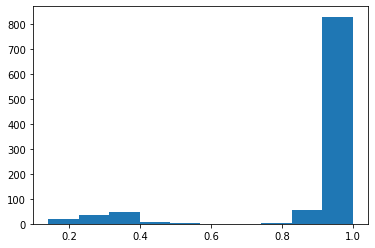

In [48]:
plt.hist(M2.predict_proba(X_tr[:1000])[:, 1])

In [69]:
#https://scikit-learn.org/stable/modules/model_persistence.html

#ff = open(r'D:\Competitions_Tasks\Sber1\W_forest_new_dataset.pkl', 'wb')
#classifier_new_pkl = pickle.dumps(M2)
#pickle.dump(classifier_new_pkl, ff)
#ff.close()

### Loading pretrained model on new data

In [111]:
ff = open(r'D:\Competitions_Tasks\Sber1\W_forest_new_dataset.pkl', 'rb')
W_forest_new = pickle.load(ff)
ff.close()

In [112]:
WWW = pickle.loads(W_forest_new)
preds = WWW.predict(X_tr)

In [113]:
TPFPTNFN(np.concatenate([Y_tr, Y_val]), np.concatenate([WWW.predict(X_tr), WWW.predict(X_val)]))

{'TP': 13304, 'FP': 220, 'TN': 1334, 'FN': 3}

In [110]:
TPFPTNFN(all_[:, -1], WWW.predict(all_[:, :-1]))

{'TP': 20834, 'FP': 2060, 'TN': 0, 'FN': 0}

(array([ 2060.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 20834.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

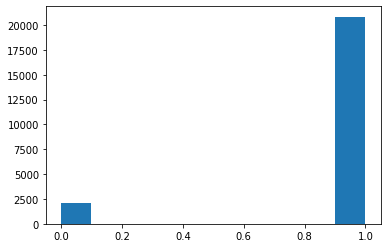

In [114]:
plt.hist(all_[:, -1])

## Testing hyperopt

In [85]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import cross_val_score
 
import hyperopt as hpt
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
 
# Для теста возьмем классический сет "ирисы Фишера"
# Разумеется вместо X и y Вам следует взять свои фичи и таргет
iris = datasets.load_iris()
X = iris.data
y = iris.target

def hyperopt_score(params, show=False):
    #clf = XGBClassifier(**params)
    clf = lm.RidgeClassifier(**params)
    # усреднение по 3ем фолдам, для уменьшения влияния стахостичности
    # для ускорения можно использовать train_test_split один раз
    current_score = cross_val_score(clf, X, y, cv=3).mean()
    if show:
        print(current_score, params,)
        print('*'*20)
    return -current_score
 
 
simple_space = {
            'alpha': hp.choice('alpha', np.linspace(0.01, 1, 100)),
            'normalize': hp.choice('normalize', [True, False]),
            'solver':  hp.choice('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
}
 
bestMy = fmin(fn=hyperopt_score, space=simple_space, max_evals=100, algo=hpt.rand.suggest, return_argmin=True)
print('\nBest:')
# Выдает индексы лучших в списке параметров
print(bestMy) 


100%|█████████████████████████████████████████████| 100/100 [00:01<00:00, 63.36trial/s, best loss: -0.8345588235294118]

Best:
{'alpha': 94, 'normalize': 0, 'solver': 0}


In [86]:
bestMy

{'alpha': 94, 'normalize': 0, 'solver': 0}

## HyperOpt on MyAlgorithms

In [130]:
clw0 = {0: round(np.count_nonzero(Y_tr)/Y_tr.shape[0],2),
       1: round(1-np.count_nonzero(Y_tr)/Y_tr.shape[0],2)}
clw0

{0: 0.9, 1: 0.1}

In [131]:
N = 100
LL = [{0: 0.3 + 0.7*i/N, 1: 0.7*(N-i)/N} for i in  range(N)]

In [132]:
#{'TP': 1997, 'FP': 216, 'TN': 15, 'FN': 1}

def Tree_score(params, show=False, hyper=1.5):
    TR = tr.DecisionTreeClassifier(**params)
    # усреднение по 3ем фолдам, для уменьшения влияния стахостичности
    # для ускорения можно использовать train_test_split один раз
    #current_score = cross_val_score(TR, X_tr, Y_tr, cv=3).mean()
    #np.concatenate([X_tr, X_val]), np.concatenate([Y_tr, Y_val])
    TR.fit(all_[:, :-1], all_[:, -1])#all_[:, :-1], all_[:, -1]
    prom = TPFPTNFN(np.concatenate([Y_tr, Y_val, Y_te]),
                    np.concatenate([TR.predict(X_tr), TR.predict(X_val), TR.predict(X_te)]))
    current_score1 = (prom['FN']*hyper + prom['FP'] + 10e-6)/((prom['TN'] + 10e-6)*2)
    if show:
        print(current_score, params,)
        print('*'*20)
    return current_score1#-current_score
 
 
tree_params = {
            'criterion': hp.choice('criterion', ['gini', 'entropy']),
            'max_depth': hp.choice('max_depth', range(2, 25)),
            'min_samples_split':  hp.choice('min_samples_split', range(5, 10)),
            'min_samples_leaf': hp.choice('min_samples_leaf', range(5, 20)),
            'class_weight': hp.choice('class_weight', ['balanced']+LL)
}
 
TRbest = fmin(fn=Tree_score, space=tree_params, max_evals=250, algo=hpt.rand.suggest, return_argmin=True)
print('\nBest:')
# Выдает индексы лучших в списке параметров
print(TRbest) 

100%|██████████████████████████████████████████████| 250/250 [15:17<00:00,  3.46s/trial, best loss: 0.3477819436183007]

Best:
{'class_weight': 55, 'criterion': 1, 'max_depth': 20, 'min_samples_leaf': 0, 'min_samples_split': 0}


In [133]:
TR = tr.DecisionTreeClassifier(criterion = ['gini', 'entropy'][TRbest['criterion']],
                               max_depth = list(range(2, 50))[TRbest['max_depth']],
                               min_samples_leaf = list(range(2, 10))[TRbest['min_samples_leaf']],
                               min_samples_split = list(range(2, 10))[TRbest['min_samples_split']],
                               class_weight = (['balanced']+LL)[TRbest['class_weight']],
                              )
TR.fit(X_tr, Y_tr)

DecisionTreeClassifier(class_weight={0: 0.6779999999999999,
                                     1: 0.32199999999999995},
                       criterion='entropy', max_depth=22, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=None, splitter='best')

In [134]:
current_score = cross_val_score(TR, X_tr, Y_tr, cv=3).mean()
current_score

0.8358274998453167

In [135]:
tp = TPFPTNFN(np.concatenate([Y_tr, Y_val]), np.concatenate([TR.predict(X_tr), TR.predict(X_val)]))
print(tp)
val_ = TPFPTNFN(Y_val, TR.predict(X_val))
print(val_)
test_ = TPFPTNFN(Y_te, TR.predict(X_te))
print(test_)

{'TP': 26226, 'FP': 559, 'TN': 2327, 'FN': 1092}
{'TP': 6154, 'FP': 502, 'TN': 190, 'FN': 705}
{'TP': 6092, 'FP': 530, 'TN': 198, 'FN': 731}


In [143]:
#!!!!best ver = 5, 0.8
M2 = ens.BaggingClassifier(TR, n_estimators=5, max_features=0.7, max_samples=0.7)
M2.fit(all_[:, :-1], all_[:, -1])# X_tr, Y_tr #all_[:, :-1], all_[:, -1]
mt_acc_tr = round(mt.accuracy_score(M2.predict(X_tr), Y_tr),3)
mt_auc_tr = round(mt.roc_auc_score(M2.predict(X_tr), Y_tr),3)
mt_acc_val = round(mt.accuracy_score(M2.predict(X_val), Y_val),3)
mt_auc_val = round(mt.roc_auc_score(M2.predict(X_val), Y_val),3)
print('\t'*2, 'Acc', '\t'*2 , 'AUC')
print('Train batch: ', mt_acc_tr,'\t'*2,  mt_auc_tr)
print('valid batch:', mt_acc_val,'\t'*2, mt_auc_val)

		 Acc 		 AUC
Train batch:  0.966 		 0.965
valid batch: 0.967 		 0.965


In [144]:
tp = TPFPTNFN(np.concatenate([Y_tr, Y_val]), np.concatenate([M2.predict(X_tr), M2.predict(X_val)]))
print(tp)
val_ = TPFPTNFN(Y_val, M2.predict(X_val))
print(val_)
test_ = TPFPTNFN(Y_te, M2.predict(X_te))
print(test_)

{'TP': 27244, 'FP': 943, 'TN': 1943, 'FN': 74}
{'TP': 6841, 'FP': 234, 'TN': 458, 'FN': 18}
{'TP': 6807, 'FP': 226, 'TN': 502, 'FN': 16}


In [148]:
#clf = pickle.dumps(M2)
#ff = open(r'D:\Competitions_Tasks\Sber1\last_model.pkl', 'wb')
#pickle.dump(clf, ff)
#ff.close()
ff = open(r'D:\Competitions_Tasks\Sber1\last_model.pkl', 'rb')
clf_pkl = pickle.load(ff)
clf = pickle.loads(clf_pkl)
ff.close()

(array([ 70.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 930.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

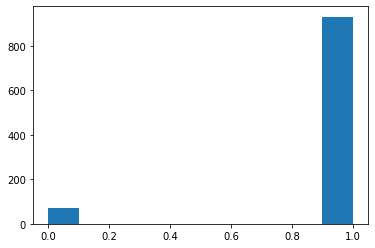

In [153]:
plt.hist(clf.predict(X_tr[:1000]))

In [100]:
# Проделаем тоже самое с hyper opt
def M2_score(params, show=False, hyper=5):
    M2 = ens.BaggingClassifier(TR, **params)
    # усреднение по 3ем фолдам, для уменьшения влияния стахостичности
    # для ускорения можно использовать train_test_split один раз
    current_score = cross_val_score(M2, X_tr, Y_tr, cv=3).mean()
    M2.fit(all_[:, :-1], all_[:, -1])
    prom = TPFPTNFN(np.concatenate([Y_tr, Y_val, Y_te]),
                    np.concatenate([TR.predict(X_tr), TR.predict(X_val), TR.predict(X_te)]))
    current_score1 = (prom['FN']*hyper + prom['FP'] + 10e-6)/((prom['TN'] + 10e-6)*2)
    if show:
        print(current_score, params,)
        print('*'*20)
    return -current_score+current_score1
 
 
M2_params = {
            'n_estimators': hp.choice('n_estimators', range(3, 50)),
            'max_features': hp.choice('max_features', np.linspace(0.1, 1.0, 100)),
}
 
#M2best = fmin(fn=M2_score, space=M2_params, max_evals=50, algo=hpt.rand.suggest, return_argmin=True)
#print('\nBest:')
# Выдает индексы лучших в списке параметров
#print(M2best) 

In [100]:
M2 = ens.BaggingClassifier(TR, 
                               n_estimators = list(range(15, 100))[M2best['n_estimators']],
                               max_features = np.linspace(0.2, 1.0, 100)[M2best['max_features']],
                              )
M2.fit(X_tr, Y_tr)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='entropy',
                                                        max_depth=28,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=3,
                                                        min_samples_split=6,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
   

In [98]:
current_score = cross_val_score(M2, X_tr, Y_tr, cv=3).mean()
current_score

0.9017574903266771

In [18]:
tp = TPFPTNFN(np.concatenate([Y_tr, Y_val]), np.concatenate([W_forest_new_.predict(X_tr),
                                                             W_forest_new_.predict(X_val)]))
print(tp)
current_score1 = (tp['FN'] + 10e-6)/(tp['TN'] + tp['FN'] + 10e-6)
current_score1

{'TP': 27204, 'FP': 949, 'TN': 1972, 'FN': 79}


0.03851780088484739

### Test

In [22]:
#test
ff = open(r'D:\Competitions_Tasks\Sber1\last_model.pkl', 'rb')
W_forest_new = pickle.load(ff)
ff.close()
W_forest_new_ = pickle.loads(W_forest_new)
preds = W_forest_new_.predict_proba(X_te)

In [23]:
preds = [1 if i[1]>0.5 else 0 for i in preds]

In [24]:
TPFPTNFN(Y_te, preds)

{'TP': 6833, 'FP': 229, 'TN': 476, 'FN': 13}

# New type_Siam on pictures

In [55]:
dir1 = r'D:\Competitions_Tasks\Sber1\bad16000'
dir2 = r'D:\Competitions_Tasks\Sber1\good16000'
dirs = [dir1, dir2]
Samples = 862; Params = 37
Nall = []; files = []
for dir_ in dirs:
    os.chdir(dir_)
    print(dir_)
    Nprom = []; FileProm = []; cnt = 0
    for filename in os.listdir()[:]:
        y, sr = librosa.load(filename, mono=True, duration=20)
        rms = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        FileProm = FileProm + [filename]
        to_append = np.concatenate([chroma_stft, rms, spec_cent,
                     spec_bw, rolloff, zcr, mfcc,])
        if to_append.shape[-1]<Samples:
            to_append = np.concatenate([to_append, np.zeros([Params, (Samples-to_append.shape[-1])])],
                                       axis = -1)
        elif to_append.shape[-1]>Samples:
            to_append = to_append[:, :Samples]
        Nprom = Nprom + [to_append]
        cnt = cnt + 1
        if cnt//10==cnt/10: print('%s/%s'%(str(cnt), str(len(os.listdir()))), end = ', ')
    print()
    files = files + [FileProm]
    Nall = Nall + [np.array(Nprom)]

D:\Competitions_Tasks\Sber1\bad16000
10/500, 20/500, 30/500, 40/500, 50/500, 60/500, 70/500, 80/500, 90/500, 100/500, 110/500, 120/500, 130/500, 140/500, 150/500, 160/500, 170/500, 180/500, 190/500, 200/500, 210/500, 220/500, 230/500, 240/500, 250/500, 260/500, 270/500, 280/500, 290/500, 300/500, 310/500, 320/500, 330/500, 340/500, 350/500, 360/500, 370/500, 380/500, 390/500, 400/500, 410/500, 420/500, 430/500, 440/500, 450/500, 460/500, 470/500, 480/500, 490/500, 500/500, 
D:\Competitions_Tasks\Sber1\good16000
10/1004, 20/1004, 30/1004, 40/1004, 50/1004, 60/1004, 70/1004, 80/1004, 90/1004, 100/1004, 110/1004, 120/1004, 130/1004, 140/1004, 150/1004, 160/1004, 170/1004, 180/1004, 190/1004, 200/1004, 210/1004, 220/1004, 230/1004, 240/1004, 250/1004, 260/1004, 270/1004, 280/1004, 290/1004, 300/1004, 310/1004, 320/1004, 330/1004, 340/1004, 350/1004, 360/1004, 370/1004, 380/1004, 390/1004, 400/1004, 410/1004, 420/1004, 430/1004, 440/1004, 450/1004, 460/1004, 470/1004, 480/1004, 490/1004, 50

In [56]:
#np.save(r'D:\Competitions_Tasks\Sber1\bad_all_features.npy', Nall[0])
#np.save(r'D:\Competitions_Tasks\Sber1\good_all_features.npy', Nall[1])

In [4]:
Nall = [np.load(r'D:\Competitions_Tasks\Sber1\bad_all_features.npy'),
        np.load(r'D:\Competitions_Tasks\Sber1\good_all_features.npy')]

In [5]:
Nall[0].shape, Nall[1].shape

((500, 37, 862), (1004, 37, 862))

In [6]:
XX1 = np.array([[Nall[0][i][:, j] for j in range(Nall[0].shape[-1])] for i in range(Nall[0].shape[0])])
XX2 = np.array([[Nall[1][i][:, j] for j in range(Nall[1].shape[-1])] for i in range(Nall[1].shape[0])])
XX1.shape, XX2.shape

((500, 862, 37), (1004, 862, 37))

In [13]:
#np.save(r'D:\Competitions_Tasks\Sber1\bad_all_features_rev_shape.npy', XX1)
#np.save(r'D:\Competitions_Tasks\Sber1\good_all_features_rev_shape.npy', XX2)

In [17]:
# Origin shape
#X = np.concatenate([Nall[0], Nall[1]])
#Y = np.array([0]*Nall[0].shape[0] + [1]*Nall[1].shape[0])
#X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2)

In [7]:
# Reversed shape
X = np.concatenate([XX1, XX2])
Y = np.array([0]*XX1.shape[0] + [1]*XX2.shape[0])
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2)

In [8]:
def WCE(y, y_pred, weights = [1.25, 1]):
    eps = 10e-6
    var = weights[0]*y*tf.log(y_pred + eps) + weights[1]*(1-y)*tf.log(1 - y_pred + eps)
    return -(tf.reduce_mean(var))

In [84]:
i0 = kl.Input(shape=X_train.shape[1:])

lstm1 = kl.LSTM(X_train.shape[2], return_sequences=True)(i0)

lstm2 = kl.LSTM(X_train.shape[2], return_sequences=True)(lstm1)

#Att
l2matmul = kl.Lambda(lambda X: tf.matmul(X[0], X[1], transpose_b=True))([lstm2, lstm2])
l2sft = kl.Softmax(axis = -1)(l2matmul)
l2att = kl.Lambda(lambda X: tf.matmul(X[0], X[1], transpose_b=False))([l2sft, lstm2])
l2att_fin = kl.Lambda(lambda X: tf.reduce_sum(X, axis = -2))(l2att)

l2avgp = kl.GlobalAveragePooling1D()(lstm2)
l2maxp = kl.GlobalMaxPooling1D()(lstm2)
l2_all = kl.Concatenate()([l2att_fin, l2avgp, l2maxp])

l3 = kl.Dense(128, activation='relu')(l2_all)
l4 = kl.Dense(1, activation='sigmoid')(l3)

md = keras.models.Model(inputs = [i0], outputs = [l4])
md.compile(optimizer=keras.optimizers.Adam(),
    loss=WCE,
    metrics=['accuracy'],)
md.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 862, 37)      0                                            
__________________________________________________________________________________________________
lstm_22 (LSTM)                  (None, 862, 37)      11100       input_29[0][0]                   
__________________________________________________________________________________________________
lstm_23 (LSTM)                  (None, 862, 37)      11100       lstm_22[0][0]                    
__________________________________________________________________________________________________
lambda_85 (Lambda)              (None, 862, 862)     0           lstm_23[0][0]                    
                                                                 lstm_23[0][0]                    
__________

In [85]:
i0 = kl.Input(shape=X_train.shape[1:])
l1 = kl.Bidirectional(kl.LSTM(X_train.shape[-1], return_sequences=True))(i0)
l1a = kl.Bidirectional(kl.LSTM(X_train.shape[-1]))(l1)

l2 = kl.Dense(X_train.shape[-1]*2, activation='relu')(l1a)
l2a = kl.Dropout(0.15)(l2)
l3 = kl.Dense(X_train.shape[-1], activation='relu')(l2a)
l4 = kl.Dense(1, activation='sigmoid')(l3)

md = keras.models.Model(inputs = [i0], outputs = [l4])
md.compile(optimizer=keras.optimizers.Adam(),
    loss=WCE,
    metrics=['accuracy'],)
md.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 862, 37)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 862, 74)           22200     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 74)                33152     
_________________________________________________________________
dense_87 (Dense)             (None, 74)                5550      
_________________________________________________________________
dropout_25 (Dropout)         (None, 74)                0         
_________________________________________________________________
dense_88 (Dense)             (None, 37)                2775      
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 38        
Total para

In [86]:
clbs = [keras.callbacks.ModelCheckpoint(r'D:\Competitions_Tasks\Sber1\HZ.h5', monitor='val_loss',
    verbose=1,
    save_best_only=True,),
       keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
    factor=0.1,
    patience=3,verbose=1)]

In [9]:
#md.fit(X_train, y_train, batch_size=8,
#    epochs=10,
#    verbose=1,
#    callbacks=clbs,
#    validation_data=[X_test, y_test],)

In [77]:
md.layers[5].call(tf.constant(X_train[0:1], dtype = tf.float32))

<tf.Tensor 'transpose_2:0' shape=(1, ?, 37) dtype=float32>

# Another method with other params

In [87]:
#md.predict([inp1[:2], inp2[:2]])
#https://github.com/CyberZHG/keras-self-attention
import sys
from keras_self_attention import SeqSelfAttention

In [88]:
q1 = np.load(r'D:\Competitions_Tasks\Sber1\bad_all_features_rev_shape.npy')
q2 = np.load(r'D:\Competitions_Tasks\Sber1\good_all_features_rev_shape.npy')

In [116]:
X = np.concatenate([q1, q2])
Y = np.array([0]*q1.shape[0] + [1]*q2.shape[0])
#X = np.expand_dims(X, axis = -1)
X.shape, Y.shape

((1504, 862, 37), (1504,))

In [120]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, Y, test_size=0.2, random_state=142)

In [140]:
i0 = kl.Input(shape=q1.shape[1:])

l1 = kl.LSTM(q1.shape[1:][-1], return_sequences=True)(i0)
# attention
l2 = kl.LSTM(q1.shape[1:][-1]*2, return_sequences=True)(l1)
# attention
l3 = kl.LSTM(q1.shape[1:][-1]*3, return_sequences=False)(l2)
# attention
# concatenate attentions

l4 = kl.Dense(256)(l3)
l5 = kl.Dense(128)(l4)
l6 = kl.Dense(1, activation='sigmoid')(l5)



md = keras.models.Model(inputs=[i0,], output=[l6,])

md.compile(optimizer=keras.optimizers.Adam(lr=0.001),
    loss=Comb, #keras.losses.binary_crossentropy,
    metrics=['accuracy'],)
md.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        (None, 862, 37)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 862, 37)           11100     
_________________________________________________________________
lstm_15 (LSTM)               (None, 862, 74)           33152     
_________________________________________________________________
lstm_16 (LSTM)               (None, 111)               82584     
_________________________________________________________________
dense_149 (Dense)            (None, 256)               28672     
_________________________________________________________________
dense_150 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_151 (Dense)            (None, 1)                 129       
Total para

D:\Soft\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [141]:
#clb = [keras.callbacks.ModelCheckpoint(r'D:\Competitions_Tasks\Sber1\NN_weights_best_val2.h5',
#                                    monitor='val_loss',
#                                    verbose=1,
#                                    save_best_only=True,), 
#       keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
#                                        factor=0.1,
#                                        patience=5)
#      ]
clb = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                    patience=1,)]

In [142]:
md.fit(X_train, y_train, batch_size=4,
    epochs=50,
    verbose=1,
      validation_data=[X_test, y_test],
      callbacks=clb)

Train on 1203 samples, validate on 301 samples
Epoch 1/50
1008/1203 [========================>.....] - ETA: 2:54 - loss: 7.8540 - acc: 0.4583

KeyboardInterrupt: 

In [48]:
l1, l2

([2, 5, 3, 6, 7, 1, 4], [10, 12, 9, 13, 8, 11, 14])

# Videos

In [1]:
import PIL
#https://stackoverflow.com/questions/51721695/dlib-installation-error
#https://stackoverflow.com/questions/56731373/vscode-v1-35-runtimeerror-cmake-must-be-installed-to-build-the-following-exte

In [6]:
dir_vid = r'D:\Competitions_Tasks\Sber2'
os.chdir(dir_vid)

In [7]:
pp = os.listdir(r'bad')

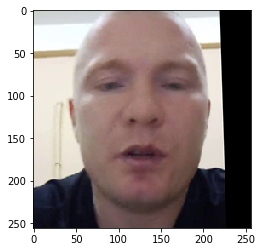

In [8]:
q = PIL.Image.open(r'bad\%s'%pp[0])
plt.imshow(q)

In [11]:
#bad = np.array([np.round(np.asarray(PIL.Image.open(r'bad\%s'%i))/255.0, 3) for i in os.listdir(r'bad')])

In [28]:
#good = np.array([np.round(np.asarray(PIL.Image.open(r'good\%s'%i))/255.0, 3) for i in os.listdir(r'good')])

In [10]:
#np.save(r'D:\Competitions_Tasks\Sber2\good_imgs.npy', good)
#np.save(r'D:\Competitions_Tasks\Sber2\bad_imgs.npy', bad)
#good = np.load(r'D:\Competitions_Tasks\Sber2\good_imgs.npy')
#bad = np.load(r'D:\Competitions_Tasks\Sber2\bad_imgs.npy')

In [10]:
X = np.concatenate([good, bad], axis=0)
Y = np.array([1]*good.shape[0] + [0]*bad.shape[0])
X.shape, Y.shape

((2323, 256, 256, 3), (2323,))

In [11]:
vgg16_pre = keras.applications.vgg16.VGG16(include_top=False,
                                                weights=None,
                                                input_shape=good.shape[1:],)
vgg16_pre.load_weights(r'C:\Users\Roman\.keras\models\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
vgg16_pre.trainable = False
vgg16_pre.summary()







_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
____

In [12]:
def WBCE(y, y_pred, weights=[1, 1]):
    eps = 10e-8
    q1 = weights[0]*y*tf.log(y_pred + eps)
    q2 = weights[1]*(1 - y)*tf.log(1 - y_pred + eps)
    return -tf.reduce_mean(q1+q2)

def SelfMetrics(y, y_pred, k=2):
    eps = 10e-8
    TP = tf.reduce_sum(y*y_pred)
    FP = tf.reduce_sum((1-y)*y_pred)
    TN = tf.reduce_sum((1-y)*(1-y_pred))
    FN = tf.reduce_sum(y*(1-y_pred))
    metr = (FN*k+FP+eps)/(TN+TP+eps)
    return metr

def F1_neg_class(y, y_pred):
    eps = 10e-8
    TP = tf.reduce_sum(y*y_pred)
    FP = tf.reduce_sum((1-y)*y_pred)
    TN = tf.reduce_sum((1-y)*(1-y_pred))
    FN = tf.reduce_sum(y*(1-y_pred))
    prec = TN/(TN+FN+eps)
    rec = TN/(TN+FP+eps)
    return (2*prec*rec)/(prec+rec+eps)

def F1_neg_class_loss(y, y_pred):
    eps = 10e-8
    TP = tf.reduce_sum(y*y_pred)
    FP = tf.reduce_sum((1-y)*y_pred)
    TN = tf.reduce_sum((1-y)*(1-y_pred))
    FN = tf.reduce_sum(y*(1-y_pred))
    prec = TN/(TN+FN+eps)
    rec = TN/(TN+FP+eps)
    return 1-(2*prec*rec)/(prec+rec+eps)

def Comb(y, y_pred, weights=[1, 3.3], k=4):
    q1 = WBCE(y, y_pred, weights=weights)
    #q2 = SelfMetrics(y, y_pred, k=k)
    q3 = F1_neg_class_loss(y, y_pred)
    return q1+q3

In [13]:
i0 = kl.Input(shape=bad.shape[1:])
md0 = vgg16_pre(i0)
l1 = kl.Flatten()(md0)
l2 = kl.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l1(0.001),
                                        bias_regularizer=keras.regularizers.l1(),)(l1)
l2a = kl.Dropout(0.15)(l2)
l3 = kl.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1(0.001),
                                        bias_regularizer=keras.regularizers.l1(),)(l2a)
l3a = kl.Dropout(0.15)(l3)
l4 = kl.Dense(1, activation='sigmoid')(l3a)

md1 = keras.models.Model(inputs=[i0], outputs=[l4])
md1.compile(optimizer=keras.optimizers.Adam(lr=0.001),
    loss=WBCE,
    metrics=['accuracy', ],)
md1.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
__________________________

In [14]:
clbs = [keras.callbacks.ModelCheckpoint(r'D:\Competitions_Tasks\Sber2\HZ.h5', monitor='val_loss',
    verbose=1,
    save_best_only=True,),
       keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
    factor=0.1,
    patience=4,verbose=1), 
       keras.callbacks.EarlyStopping(monitor='val_loss',
    patience=8,)]

In [16]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
X_train.shape

(1858, 256, 256, 3)

In [ ]:
md1.fit(X_train, y_train, batch_size=8,
    epochs=50,
    verbose=1,
    callbacks=clbs,
    validation_data=[X_test, y_test],)